<a href="https://colab.research.google.com/github/shrutikohli/machine-learning-examples/blob/master/Updated_Anomaly_SH_ESD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection in Univariate Time Series

The following code aims at showing a simple case of anomaly detection for univariate time series. This code will use the `pyculiarity` Python package which implements the Seasonal-Hybrid Extreme Studentize Deviate algorithm which has been developed by Twitter.
For more information on this algorithm, the reader should read the following paper written by the Twitter team: https://arxiv.org/pdf/1704.07706.pdf. 

The `pyculiarity` package is available as a Python package which can simply be installed using `pip install pyculiarity`. The code of the package can be viewed at https://github.com/zrnsm/pyculiarity.

To test the package, we will use one of the Numenta Anomaly Benchmark dataset, which are available at: https://github.com/numenta/NAB (see folder Data). 

Specifically we will use the dataset *machine_temperature_system_failure.csv* which is located in the *realKnownCause* subfolder

## Package import and data load

Let's start with importing the necessary packages and load the file containing the data. We have located the *machine_temperature_system_failure.csv* file in a `data` folder in the same folder at this Jupyter notebook. 

The necessary package to work with are `pandas` and `pyculiarity` together with `matplotlib` for charts.

In [0]:
!pip install pyculiarity

    100% |████████████████████████████████| 163kB 948kB/s ta 0:00:01
  Stored in directory: /Users/shrutikohli/Library/Caches/pip/wheels/a9/21/34/7b498ad7607df574cf8b8a9a3b1480cfe641efdfba369e9b6c
Successfully built pyculiarity


In [0]:
# First load the Python libraries
import pandas as pd
from pyculiarity import detect_ts
import matplotlib.pyplot as plt
import seaborn
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

seaborn.set()
%matplotlib inline

In [0]:
# Second, load the data file
machine_temp = pd.read_csv('data/machine_temperature_system_failure.csv')
machine_temp.shape

(22695, 2)

In [0]:
machine_temp.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


## Data selection

We are going to work only on a subset of the data, starting on February 1st, 2014 and ending at the end of the dataset. 

In [0]:
machine_temp['timestamp'] = pd.to_datetime(machine_temp['timestamp'])
df = machine_temp[machine_temp['timestamp'] > '2014-02-01 00:00:00']

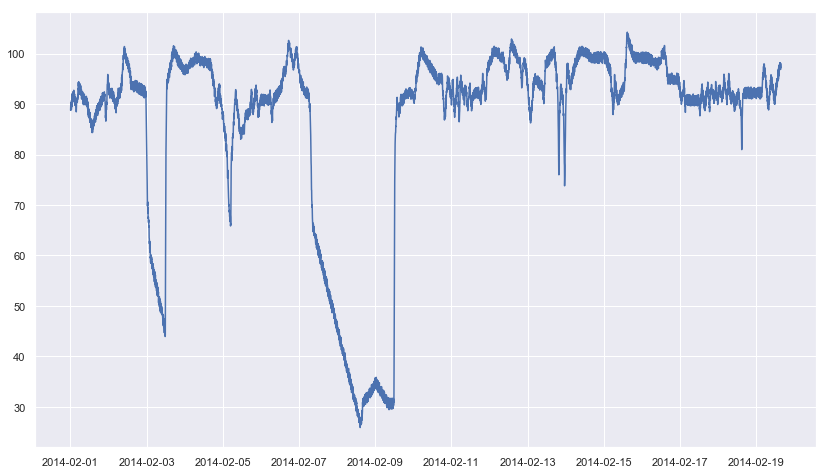

In [0]:
plt.figure(figsize=(14,8))
plt.plot(df['timestamp'], df['value'])

## Anomaly detection

We are now going to apply the `detect_ts` function from the `pyculiarity` package to detect anomalies in the timeserie. 

The `detect_ts` takes several parameters, but the main parameter we are going to be concerned about is the `max_anoms` parameter. It defines what is the maximum number of anomalies the algorithm is supposed to find as a ratio of the total number of points. So `max_anoms=0.05` means that only 5% of the points are considered anomalies. 

Another parameter of importance is `direction` which stipulates whether we should look at anomalies that are positive, negative with regards to the time series or both. Given the chart above, we will focus on negative anomalies. 

In [0]:
anoms = detect_ts(df, max_anoms=0.05, direction='neg')

In [0]:
type(anoms)

dict

In [0]:
anoms.keys()

dict_keys(['anoms', 'plot'])

In [0]:
anoms['anoms'].head()

,timestamp,anoms
timestamp,,
2014-02-08 10:50:00,2014-02-08 10:50:00,31.045737
2014-02-08 10:55:00,2014-02-08 10:55:00,32.313084
2014-02-08 11:05:00,2014-02-08 11:05:00,30.797376
2014-02-08 11:10:00,2014-02-08 11:10:00,31.477618
2014-02-08 11:15:00,2014-02-08 11:15:00,31.764432


### Plotting anomalies

Let's now plot anomalies on the initial chart to see what the SH-ESD algorithm has found and see graphically whether it makes sense or not.

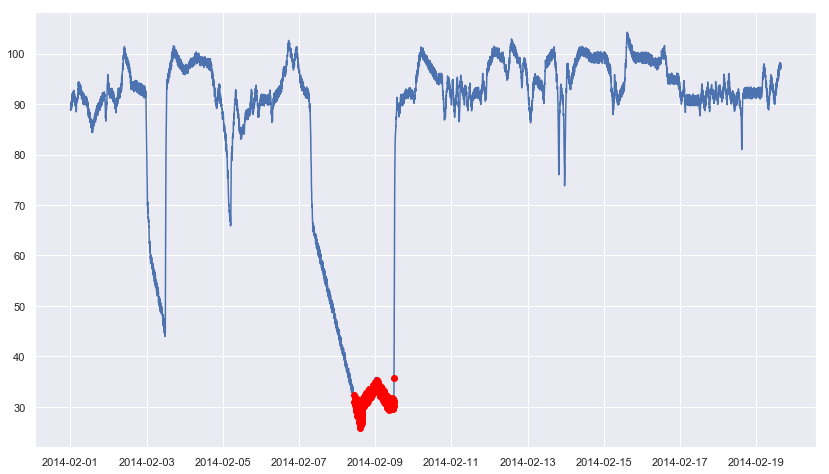

In [0]:
plt.figure(figsize=(14,8))
plt.plot(df['timestamp'], df['value'])
plt.plot(anoms['anoms'].timestamp, anoms['anoms'].values[:,1], 'ro', color='red')

As we can see, the algorithm has spotted the most extreme anomaly, but not the others (3rd of Feb, 5th of Feb and 13th of Feb). But since we constrained the algorithm to a number of anomalies that cannot exceed 5% of the dataset, the algorithm went to the most extreme, which is expected. 

So as we can see, the parameter `max_anoms` is critical here. Before we start adjusting it, let's see what would be the impact of changing the parameter `direction`. In the case above, we set it to `neg` which makes sense since we see anomalies are all negative compared the **normal** data. But in a typical anomaly detection case, we would not know what kind of anomalies we face and would thus not be able to predict the direction. 

### Adjusting direction

So let's take the same parameters as above and simply change the `direction` parameter to see if this creates a different kind of detection.

In [0]:
anoms2 = detect_ts(df, max_anoms=0.05, direction='both')

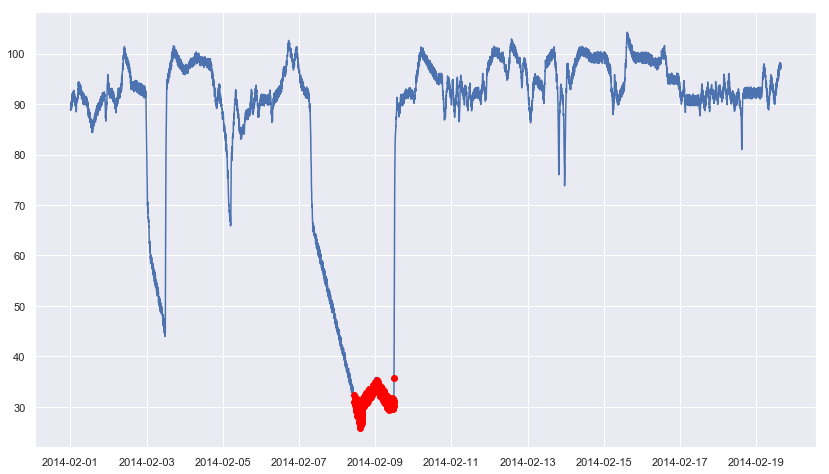

In [0]:
plt.figure(figsize=(14,8))
plt.plot(df['timestamp'], df['value'])
plt.plot(anoms2['anoms'].timestamp, anoms2['anoms'].values[:,1], 'ro', color='red')

So far so good, we have not biased the detection initially by setting the direction. Let's now see how the model evolve by increasing the `max_anoms` parameter which represents the maximum number of anomalies to detect. 

## `max_anoms` increase
### `max_anoms=0.1`
#### `direction='neg'`

In [0]:
anoms3 = detect_ts(df, max_anoms=0.1, direction='neg')

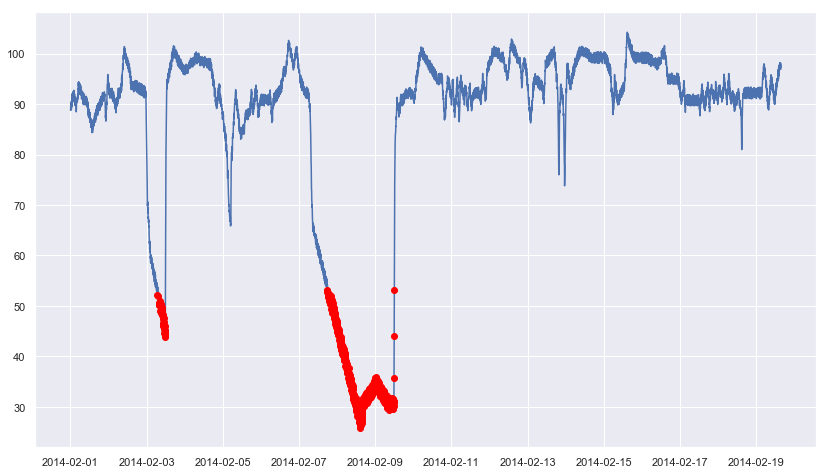

In [0]:
plt.figure(figsize=(14,8))
plt.plot(df['timestamp'], df['value'])
plt.plot(anoms3['anoms'].timestamp, anoms3['anoms'].values[:,1], 'ro', color='red')

#### `direction='both'`

In [0]:
anoms4 = detect_ts(df, max_anoms=0.1, direction='both')

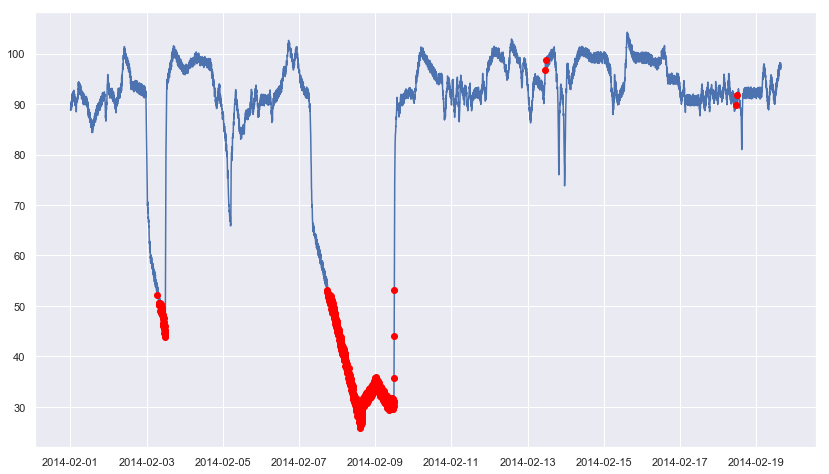

In [0]:
plt.figure(figsize=(14,8))
plt.plot(df['timestamp'], df['value'])
plt.plot(anoms4['anoms'].timestamp, anoms4['anoms'].values[:,1], 'ro', color='red')

As expected, the model now spots more anomalies compared to the previous one with `max_anoms=0.05`. This is not surprising given that there are more anomalies in the dataset. 

Interestingly, the models with different `direction` parameters start to diverge, even though only slightly. The second model spots more anomalies than the first, even though it still misses obvious ones that the reader will have noticed (5th of February and negative anomaly on the 13th of February). But it identified positive anomalies that a human may have difficulty to notice. Only domain knowledge would help in clarifying whether these are real anomalies or not. 

Let's increase our `max_anoms` parameter and see what this gives and far will both models diverge with regards to the `direction` parameter

### `max_anoms=0.2`
#### `direction='neg'`

In [0]:
anoms5 = detect_ts(df, max_anoms=0.2, direction='neg')

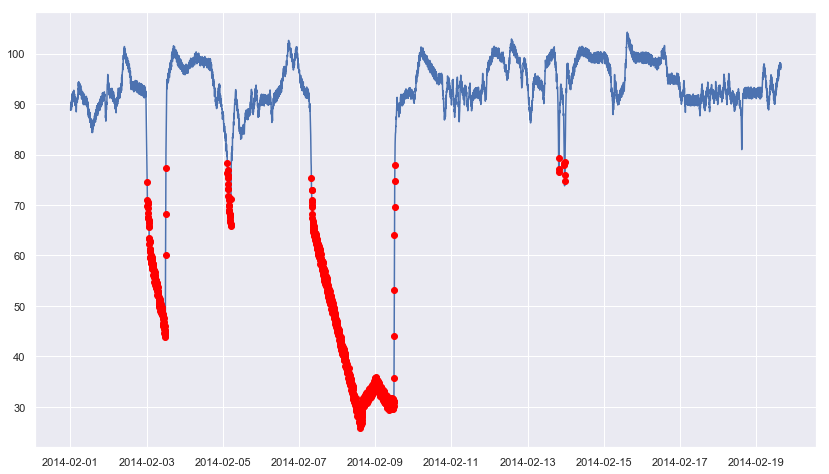

In [0]:
plt.figure(figsize=(14,8))
plt.plot(df['timestamp'], df['value'])
plt.plot(anoms5['anoms'].timestamp, anoms5['anoms'].values[:,1], 'ro', color='red')

#### `direction='both'`

In [0]:
anoms6 = detect_ts(df, max_anoms=0.2, direction='both')

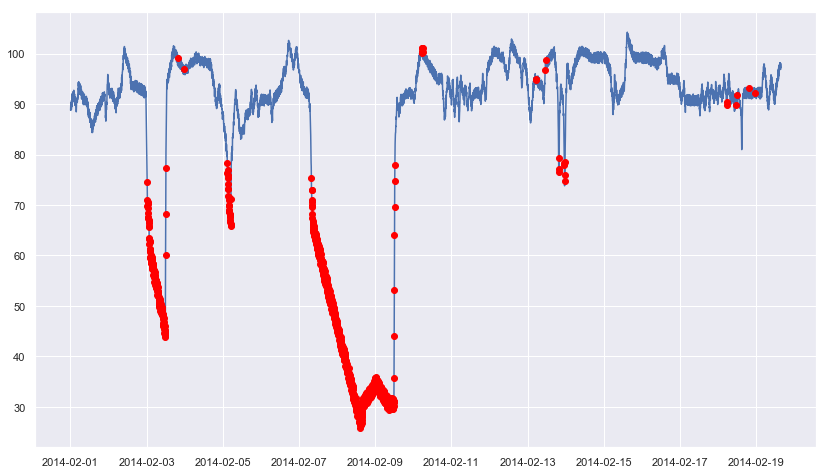

In [0]:
plt.figure(figsize=(14,8))
plt.plot(df['timestamp'], df['value'])
plt.plot(anoms6['anoms'].timestamp, anoms6['anoms'].values[:,1], 'ro', color='red')

### `max_anoms=0.3`
#### `direction='neg'`

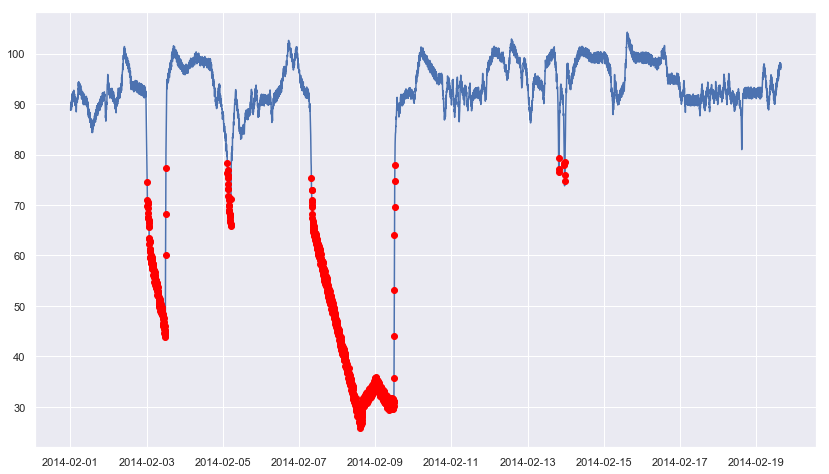

In [0]:
anoms7 = detect_ts(df, max_anoms=0.3, direction='neg')
plt.figure(figsize=(14,8))
plt.plot(df['timestamp'], df['value'])
plt.plot(anoms7['anoms'].timestamp, anoms7['anoms'].values[:,1], 'ro', color='red')

#### `direction='both'`

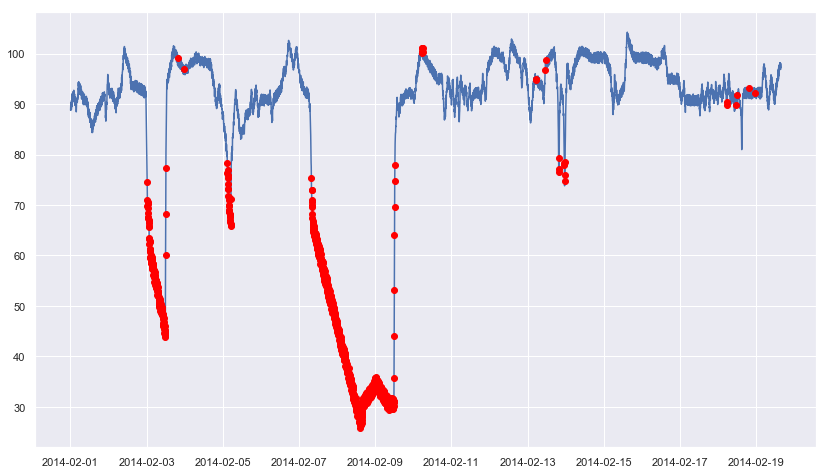

In [0]:
anoms8 = detect_ts(df, max_anoms=0.3, direction='both')
plt.figure(figsize=(14,8))
plt.plot(df['timestamp'], df['value'])
plt.plot(anoms8['anoms'].timestamp, anoms8['anoms'].values[:,1], 'ro', color='red')

We continue increasing `max_anoms` until 0.49 and see where it leads us in terms of anomaly detection. But as we can see, our model that looks at anomalies in both direction seems to perform better in terms of identifying anomalies than the one looking only at negative anomalies. However, deciding what to look for is mostly a domain specific question. In this case, we are looking temperature indicative of system failure so we might consider only negative anomalies are worth exploring. 

A key question is to understand where to stop in terms of defining the right amount of `max_anoms`. In this case, we can answer the question by comparing the number of anomalies found when `max_anoms` is 0.2 and when it is 0.3.

### Comparing different ratios of `max_anoms`

#### `direction='neg'`
To compare we need to look at 2 objects:
- `anoms5`
- `anoms7`

In [0]:
len(anoms5['anoms'].values) == len(anoms7['anoms'].values)

True

In this case, there was no improvement by increasing `max_anoms`.

#### `direction='both'`
We now need to compare 2 objects:
- `anoms6`
- `anoms8`

In [0]:
len(anoms6['anoms'].values) == len(anoms8['anoms'].values)

True

Again no improvement in increasing `max_anoms` here. 